In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN
from models.WGAN_model.WGAN import WGAN

import torch
import pytorch_lightning as pl
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # hyperparameters
# z_dim = 100
latent_dim = 100
output_dim=1
negative_slope = 0.2
init_resolution_size=(8,5)
batch_size = 64
depths = [256, 256, 128, 64, 32, 16]
num_epochs = 60
num_epochs_per_resolution = int(num_epochs / len(depths))
learning_rate = 5e-5
n_critic = 5
c = 0.01
fade_in_percentage = 0.5
# lambda - for WGAN-GP
# beta1 = 0.5
normalization = True
mini_batch_normalization = False
# loss - change and define

# base_directory = "../data/raw/nsynth-train/audio"
# base_directory = "../data/raw/Bass-train"
base_directory = "../data/raw/Bass"

dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
Music_WPGAN = WGAN(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    depths=depths, 
    negative_slope=negative_slope,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
    c=c,
    n_critic=n_critic
)

In [6]:
Music_WPGAN.train(dataloader=dataloader, fade_in_percentage=fade_in_percentage)

Resolution 0 - Epoch 1/10 - D Loss: -38.068809509277344 - G Loss: -44.50154495239258
(1, 8, 5)


ZeroDivisionError: float division by zero

<Figure size 1000x500 with 0 Axes>

In [14]:
Music_WPGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=2)
        (3): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=2)
      )
      (1): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=2)
        (3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=2)
      )
      (1): Sequential(
        (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(
      (

In [15]:
z = torch.randn(1, Music_WPGAN.latent_dim).to(Music_WPGAN.device)
generated_spectrogram = Music_WPGAN.generator(z)

In [16]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
spectrogram = spectrogram.squeeze()

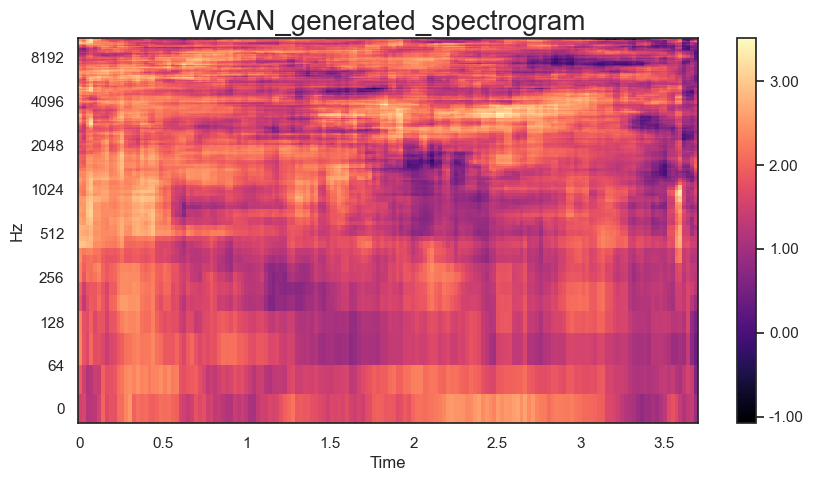

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('WGAN_generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [15]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'WPGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)